# Scenario modelling

In [1]:
scn = "SCN_BASE"
BASELINE = "BASELINE"
SCN_BASE = "SCN_BASE"
SCN_MIN_LEY = "SCN_MIN_LEY"
SCN_REDUCED_MILK = "SCN_REDUCED_MILK"
SCN_SNG = "SCN_SNG"

## Set up environment

In [2]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

In [3]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [4]:
from CIBUSmod.utils.misc import inv_dict, aggregate_data_coords_pair
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint
from itertools import product

In [5]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

In [6]:
def block_print(msg: str, N=80):
    print("=" * N)
    print("=" * N)
    if len(msg) >= N-2:
        print(msg)
    else:
        _n = int((N - len(msg)) / 2) - 1
        _n2 = _n + len(msg) % 2
        print(_n * "-" + f" {msg} " + "-" * _n2)
    print("=" * N)
    print("=" * N)

In [7]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = "data",
    data_path_default = CM_BASEPATH + "/data/default",
)

## Share of land use per region

In [8]:
x0_lu_per_region = session.get_attr("r", "x0_crops", "region")
x_lu_per_region = session.get_attr("f", "x_crops", "region")
delta_lu_per_region = (x0_lu_per_region - x0_lu_per_region)

In [9]:
for _scn, year in delta_lu_per_region.index:
    if all(delta_lu_per_region == 0):
        block_print(f"{_scn}: All land used")
        print("")
    else:
        print(_scn)
        cm.plot.map_from_series(delta_lu_per_region[(_scn, year)])

--------------------------- BASELINE: All land used ----------------------------

--------------------------- SCN_BASE: All land used ----------------------------

-------------------------- SCN_MIN_LEY: All land used --------------------------

----------------------- SCN_REDUCED_MILK: All land used ------------------------

---------------------------- SCN_SNG: All land used ----------------------------



## Change in crops

Plots if crops increased or decarsed in amounts in each region.

### Change in total crops per region, compared to x0

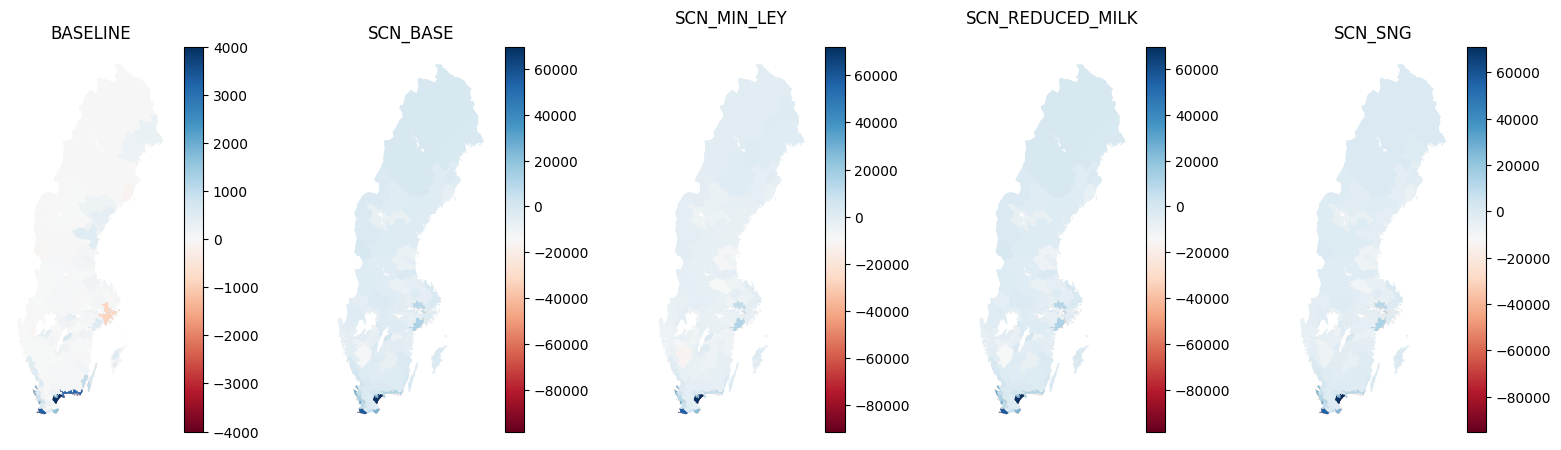

In [10]:
x0_crops_per_region = session.get_attr("r", "x0_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
x_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
delta = x_crops_per_region - x0_crops_per_region

fig, axs = plt.subplots(1, len(session.scenarios()), figsize=(20, 5))
for scn, ax in zip(list(session.scenarios().keys()), axs):
    try:
        data = delta.loc[(scn, "2020"),:]
    except Exception:
        continue
    
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(delta.loc[(scn, "2020"),:], cmap="RdBu", ax=ax)

### Change in total crops per region, compared to the baseline

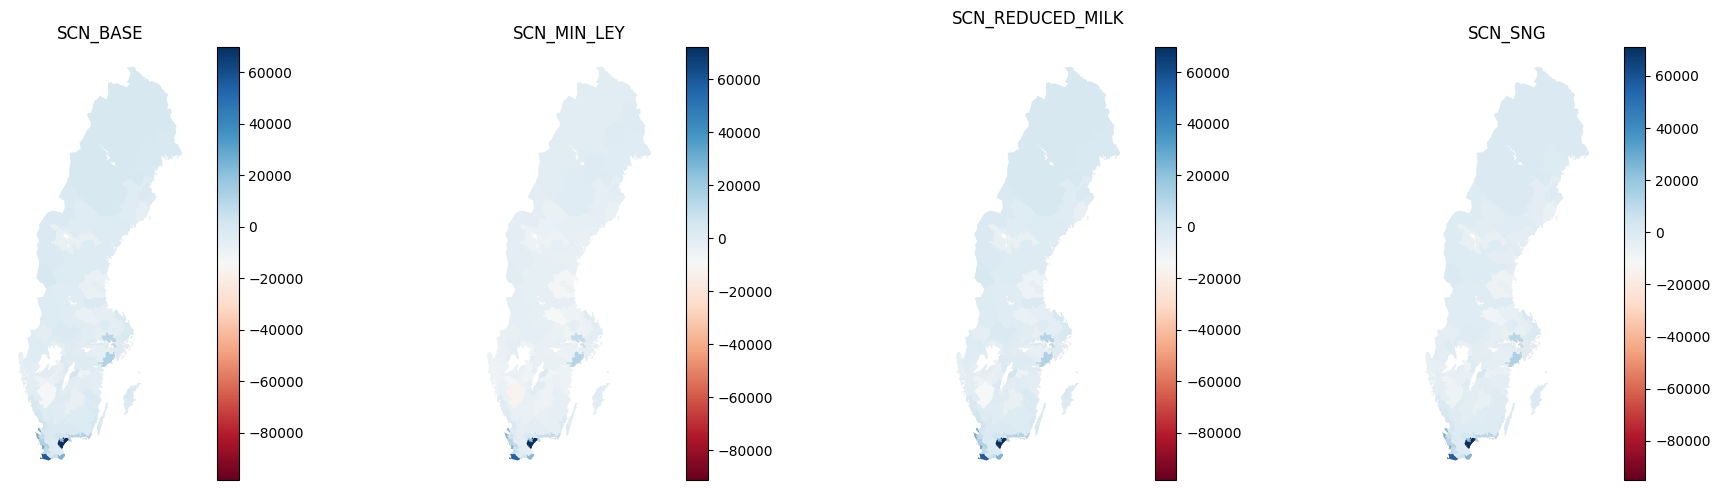

In [11]:
BL_crops_per_region = session.get_attr("r", "x0_crops", ["prod_system", "region"], scn="BASELINE").loc[("BASELINE","2020")]
SCNS_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
SCNS_crops_per_region = SCNS_crops_per_region.drop([("BASELINE", "2020")])
delta = SCNS_crops_per_region - BL_crops_per_region

scenarios = [s for s in session.scenarios().keys() if s != "BASELINE"]
fig, axs = plt.subplots(1, len(scenarios), figsize=(20, 5))
for scn, ax in zip(scenarios, axs):
    ax.set_axis_off()
    ax.set_title(scn)
    
    try:
        data = delta.loc[(scn, "2020"),:]
    except Exception:
        continue
    
    plot.map_from_series(data, cmap="RdBu", ax=ax)
fig.tight_layout()

## Share of byproducts used

In [12]:
D_byprod = session.get_attr("d", "by_products")
# Subtract food uses of by-products
used_byprod = session.get_attr("d", "by_prod_demand").xs("food", level="demand", axis=1)
D_byprod = D_byprod - used_byprod.reindex(D_byprod.columns, axis=1).fillna(0)
D_byprod

prod_system            conventional                                     \
by_prod                  apple pulp barley brewers grain   butcher fat   
origin                     domestic             domestic      domestic   
scn              year                                                    
BASELINE         2020  5.084329e+06         9.312015e+07  5.577411e+07   
SCN_BASE         2020  5.084329e+06         9.312015e+07  4.244275e+07   
SCN_MIN_LEY      2020  5.084329e+06         9.312015e+07  4.244275e+07   
SCN_REDUCED_MILK 2020  5.084329e+06         9.312015e+07  4.244275e+07   
SCN_SNG          2020  5.084329e+06         9.312015e+07  4.244275e+07   

prod_system                                                                    \
by_prod                  buttermilk  edible blood edible offals      feathers   
origin                     domestic      domestic      domestic      domestic   
scn              year                                                           
BASELINE         2020  3.706088e+07  1.993502e+07  2.126410e+07  4.384669e+07   
SCN_BASE         2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   
SCN_MIN_LEY      2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   
SCN_REDUCED_MILK 2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   
SCN_SNG          2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   

prod_system                                                         ...  \
by_prod                   fish meal inedible blood inedible offals  ...   
origin                     imported       domestic        domestic  ...   
scn              year                                               ...   
BASELINE         2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_BASE         2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_MIN_LEY      2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_REDUCED_MILK 2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_SNG          2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   

prod_system                      organic                \
by_prod               slaughterhouse fat  soybean meal   
origin                          domestic      imported   
scn              year                                    
BASELINE         2020       1.916671e+06  3.794208e+06   
SCN_BASE         2020       5.002065e+05  3.764469e+06   
SCN_MIN_LEY      2020       5.002065e+05  3.764469e+06   
SCN_REDUCED_MILK 2020       5.002065e+05  3.764469e+06   
SCN_SNG          2020       5.002065e+05  3.764469e+06   

prod_system                                                            \
by_prod               soybean protein concentrate sugar beet molasses   
origin                                   imported            imported   
scn              year                                                   
BASELINE         2020                53026.107968        6.441660e+07   
SCN_BASE         2020                53024.933125        5.607111e+04   
SCN_MIN_LEY      2020                53024.933125        5.607111e+04   
SCN_REDUCED_MILK 2020                53024.933125        5.607111e+04   
SCN_SNG          2020                53024.933125        5.607111e+04   

prod_system                                                \
by_prod               sugar beet pulp sunflower seed meal   
origin                       imported            imported   
scn              year                                       
BASELINE         2020    4.041989e+07        76669.915795   
SCN_BASE         2020    7.595611e+04        76597.969772   
SCN_MIN_LEY      2020    7.595611e+04        76597.969772   
SCN_REDUCED_MILK 2020    7.595611e+04        76597.969772   
SCN_SNG          2020    7.595611e+04        76597.969772   

prod_system                                                               \
by_prod               wheat distillers grain                        whey   
origin                              domestic

(<Axes: >, [<Axes: label='inset_axes'>])

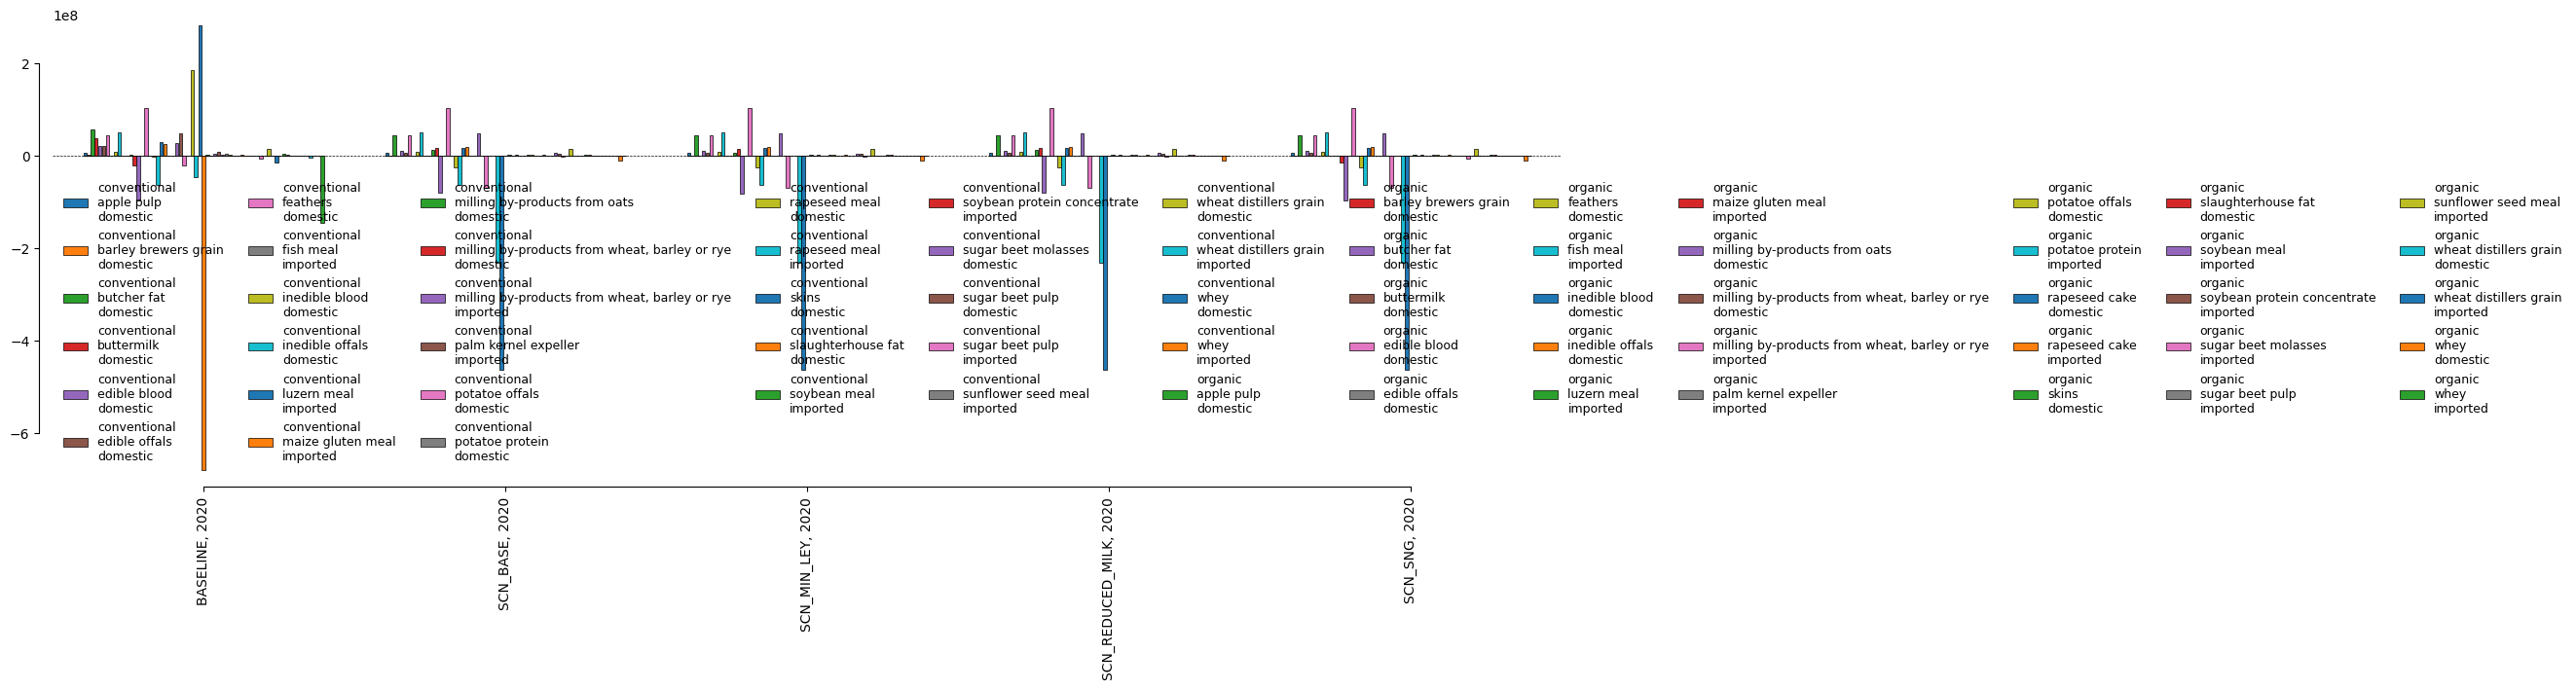

In [13]:
F_byprod = session.get_attr("ani", "feed.by_product_demand", ["prod_system", "by_prod"])
F_byprod = F_byprod.reindex(D_byprod.columns, axis=1).fillna(0)
net_byprod = D_byprod - F_byprod

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
plot.bar(
    net_byprod,
    stacked=False,
    ax=ax
)

,animal_prod,milk,meat
scn,year,,
BASELINE,2020,2.817160e+09,5.438627e+08
SCN_BASE,2020,1.819319e+09,4.554598e+08
SCN_MIN_LEY,2020,1.912756e+09,5.468231e+08
SCN_REDUCED_MILK,2020,1.579779e+09,4.597820e+08
SCN_SNG,2020,1.819319e+09,4.856709e+08


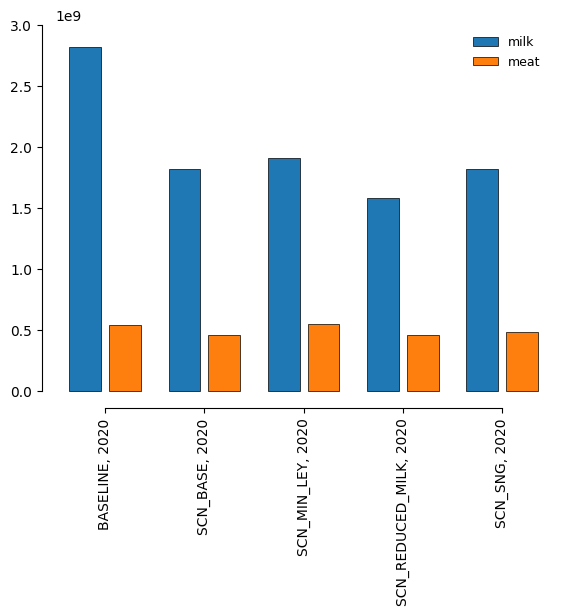

In [14]:
meatmilk_prod = session.get_attr('a', 'production', "animal_prod")[["milk", "meat"]]
plot.bar(meatmilk_prod, stacked=False)
meatmilk_prod

,crop,Wheat (add),Peas (add)
scn,year,,
SCN_BASE,2020,5.459926e+09,1.155990e+09
SCN_MIN_LEY,2020,3.053061e+09,1.151522e+09
SCN_REDUCED_MILK,2020,5.497438e+09,1.156028e+09
SCN_SNG,2020,4.678422e+09,1.151611e+09


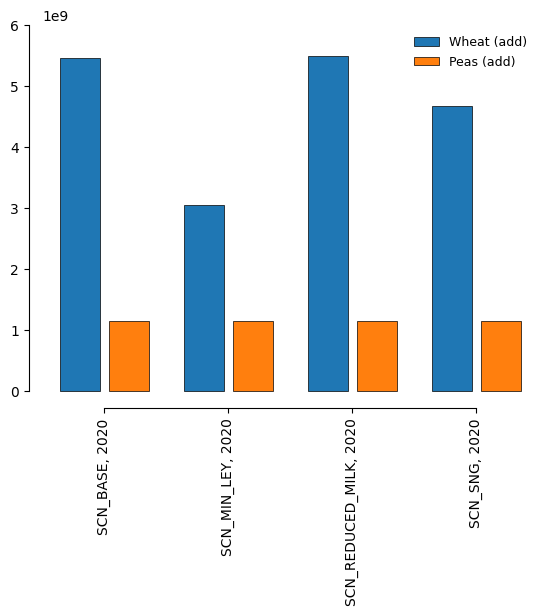

In [15]:
crop_prod = session.get_attr("c", "harvest", "crop")[["Wheat (add)", "Peas (add)"]]
crop_prod = crop_prod.drop(("BASELINE", "2020"))
plot.bar(crop_prod, stacked=False)
crop_prod

## Chloropleth maps over added crops/meat

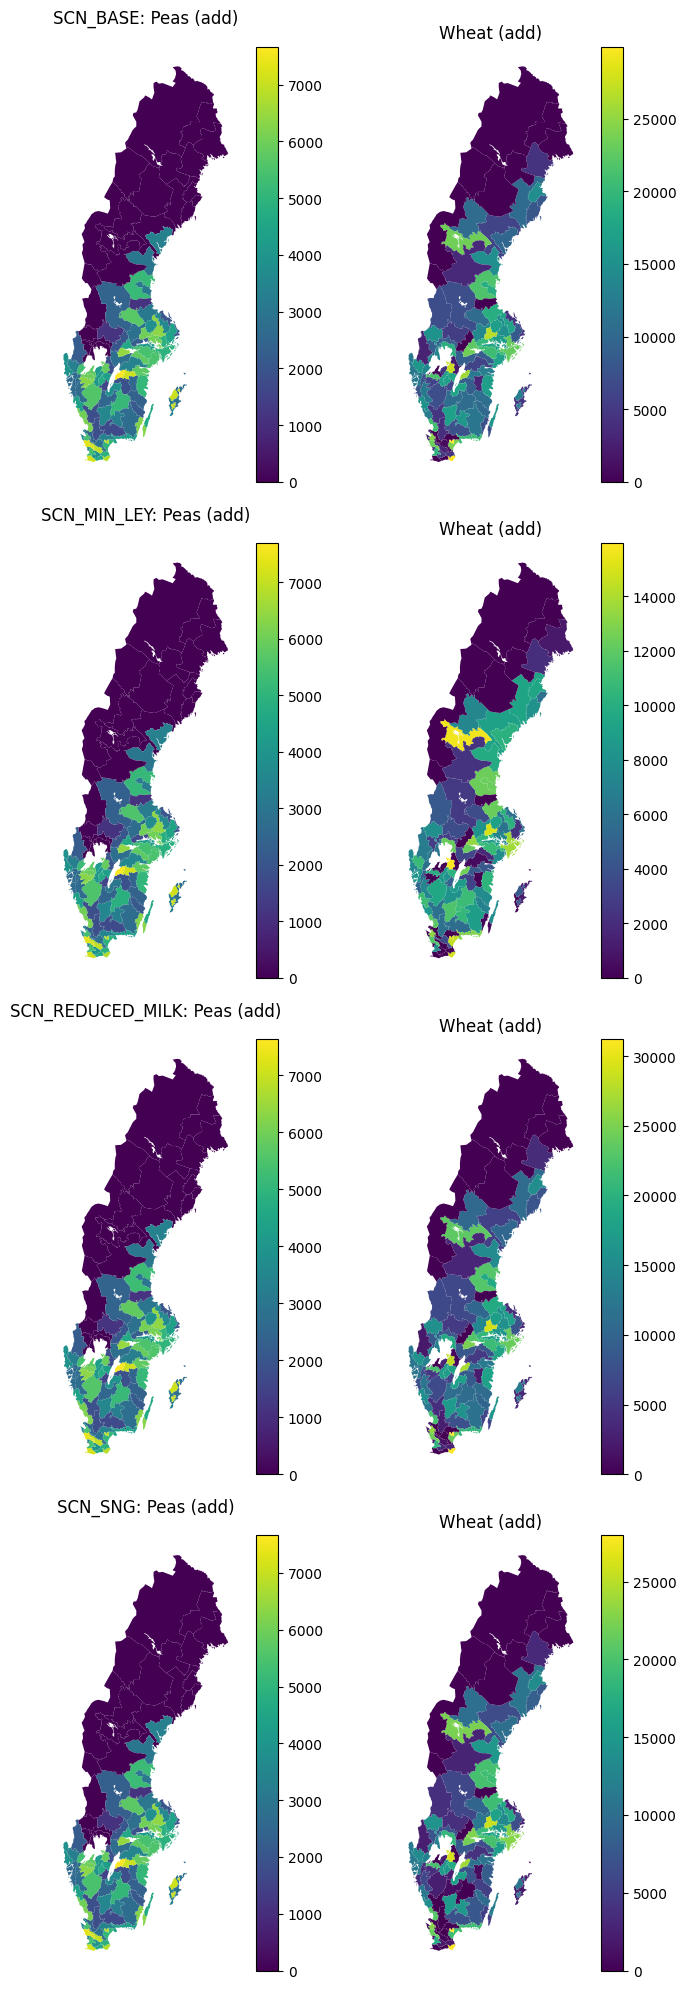

In [16]:
def plot_crop_x0_x_chloropleths(): 
    def get_x(crp: str):
        return session.get_attr("f", "x_crops").xs(crp, level="crop", drop_level=False, axis=1)
    
    crops = pd.concat([get_x("Peas (add)"), get_x("Wheat (add)")], axis=1)
    cps = crops.columns.unique("crop")
    crops = crops.drop(("BASELINE", "2020"))

    ncols = len(cps)
    nrows = crops.shape[0]
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*5))

    if nrows == 1:
        axs = [axs]

    for scn_i, (scn, _year) in enumerate(crops.index):
        for crp_i, crp in enumerate(cps):
            data=crops.loc[(scn, _year),(crp, "conventional",)]
            ax=axs[scn_i][crp_i]
            ax.set_axis_off()
            title = crp
            if crp_i == 0:
                title = f"{scn}: {title}"
            ax.set_title(title)
                
            cm.plot.map_from_series(data, ax=ax)
    fig.tight_layout()

plot_crop_x0_x_chloropleths()

----------------------------------- SCN_BASE -----------------------------------


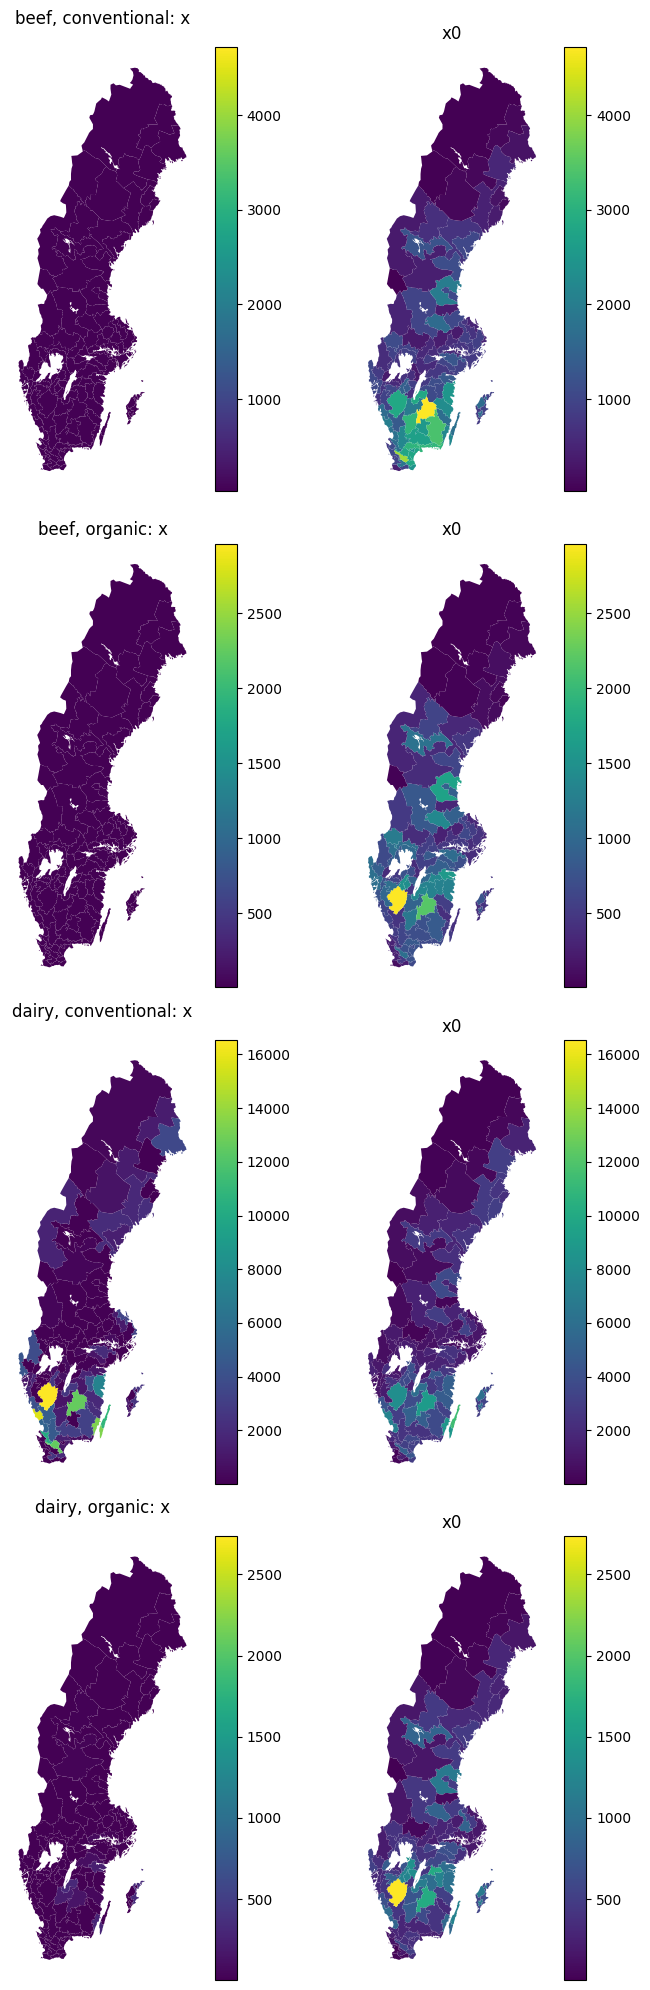

--------------------------------- SCN_MIN_LEY ----------------------------------


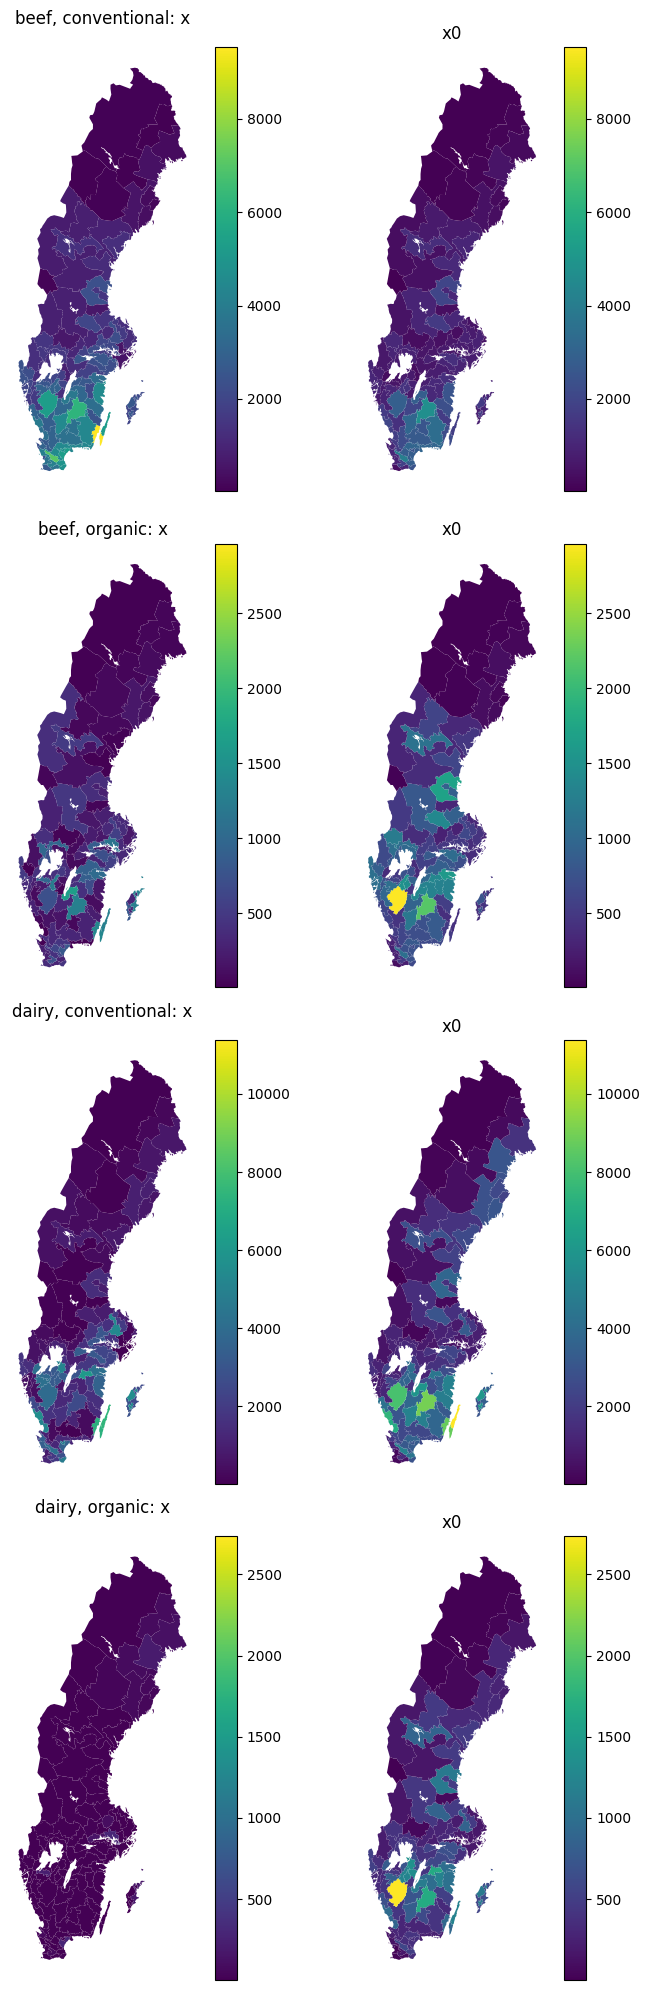

------------------------------- SCN_REDUCED_MILK -------------------------------


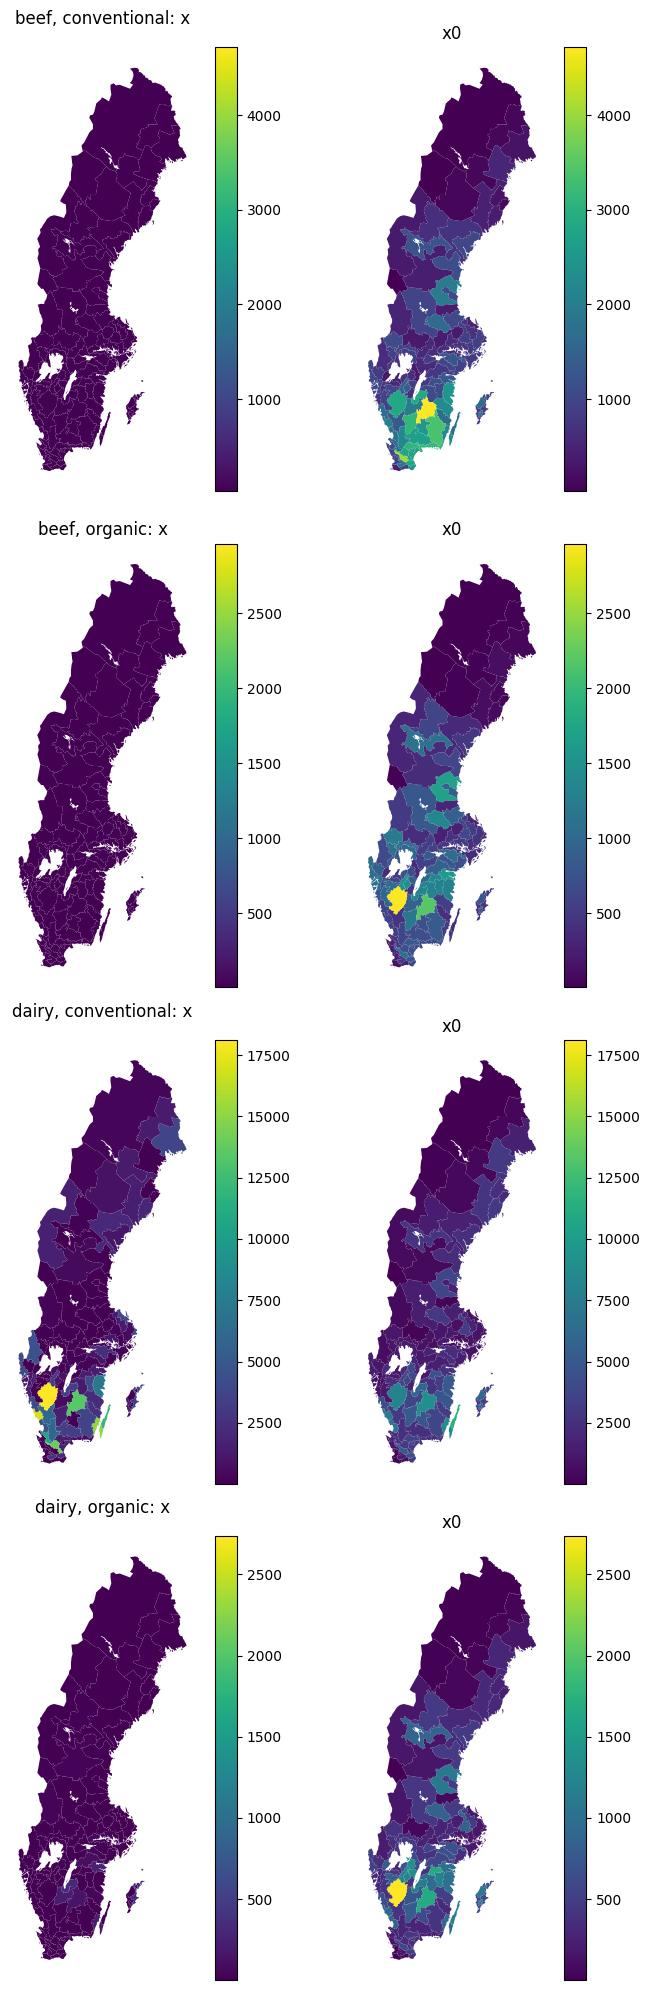

----------------------------------- SCN_SNG ------------------------------------


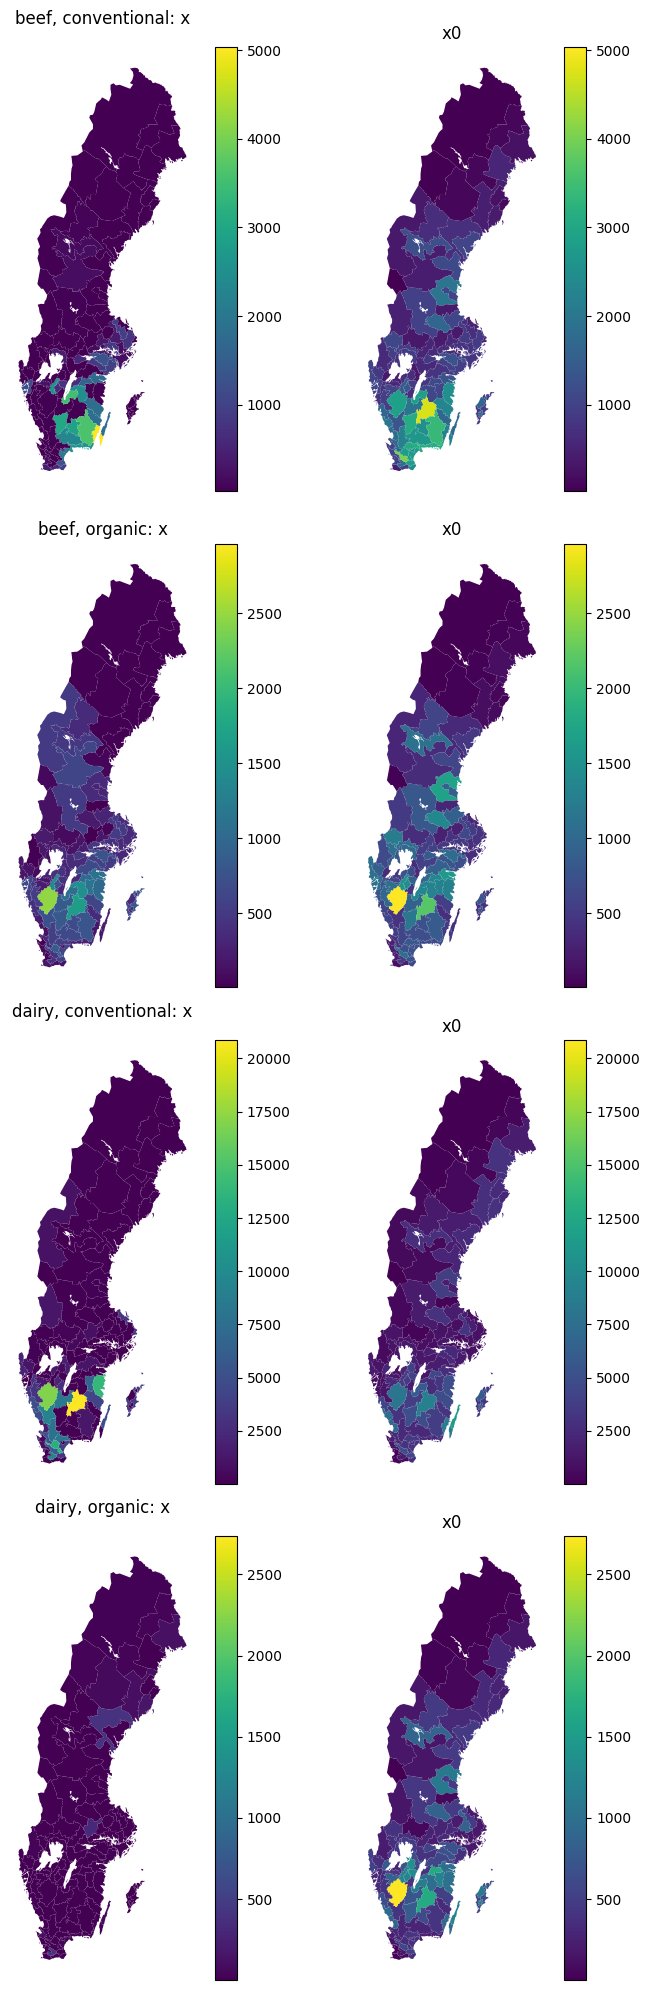

In [17]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

def plot_cattle_x0_x_chloropleths():
    all_x0_cattle = session.get_attr("r", "x0_animals").xs("cattle", level="species", axis=1)
    all_x_cattle = session.get_attr("f", "x_animals", ["species", "breed", "prod_system", "region"]).xs("cattle", level="species", axis=1)

    for scn in all_x_cattle.index.get_level_values("scn"):
        if scn == "BASELINE": 
            continue
        block_print(scn)
        x0_cattle = all_x0_cattle.loc[(scn, "2020")].unstack("region")
        x_cattle = all_x_cattle.loc[(scn, "2020")].unstack("region")
        
        assert (x0_cattle.index == x_cattle.index).all(), "Expected index of x0 and x to match"
        
        N = len(x0_cattle.index.values)
        fig, axes = plt.subplots(N, 2, figsize=(8, N * 5))
        
        for pos, axs in zip(x0_cattle.index, axes):
            (ax_x, ax_x0) = axs
            
            x = x_cattle.loc[pos,:]
            x0 = x0_cattle.loc[pos,:]
            
        
            # Absolute values: x and x0
            # -------------------------
            ax_x.set_axis_off()
            ax_x0.set_axis_off()
            x_vmax = max(x.max(), x0.max())
            x_vmin = max(x.min(), x0.min())
            ax_x.set_title(f"{pos[0]}, {pos[1]}: x")
            ax_x0.set_title("x0")
            cm.plot.map_from_series(x, ax=ax_x, vmin=x_vmin, vmax=x_vmax)
            cm.plot.map_from_series(x0, ax=ax_x0, vmin=x_vmin, vmax=x_vmax)
        
        fig.tight_layout()
        plt.show()

plot_cattle_x0_x_chloropleths()

In [18]:
session.get_attr("f", "x_crops").xs("Peas (add)", level="crop", axis=1)

prod_system           conventional                                         \
region                        1011          111         1111         1112   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  4299.123078  4930.589177  5032.552697  3393.174428   
SCN_MIN_LEY      2020  4299.123078  4843.735446  4925.289350  3455.454189   
SCN_REDUCED_MILK 2020  4299.123078  4989.637508  5032.552697  3360.028908   
SCN_SNG          2020  4291.918339  4907.931452  5032.552697  3428.397054   

prod_system                                                                \
region                         112         1121         1122         1123   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  4407.735797  6804.505212  4909.707611  5410.217948   
SCN_MIN_LEY      2020  4485.645540  6804.067994  4909.707611  5405.611718   
SCN_REDUCED_MILK 2020  4361.378955  6804.954760  4909.707611  5410.217948   
SCN_SNG          2020  4410.689540  6804.863447  4886.475684  5407.684860   

prod_system                                      ...               \
region                        1124         1131  ...          731   
scn              year                            ...                
BASELINE         2020     0.000000     0.000000  ...     0.000000   
SCN_BASE         2020  2515.961766  1847.470559  ...  1726.912904   
SCN_MIN_LEY      2020  2489.920963  1847.470559  ...  1726.912904   
SCN_REDUCED_MILK 2020  2516.559652  1847.470559  ...  1726.912904   
SCN_SNG          2020  2481.580426  1838.470481  ...  1707.396194   

prod_system                                                                \
region                         811          812          813          814   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  6255.772106  4600.979253  2125.961109  2379.029252   
SCN_MIN_LEY      2020  6286.469109  4595.495364  2125.961109  2379.029252   
SCN_REDUCED_MILK 2020  6252.347511  4606.531789  2125.961109  2379.029252   
SCN_SNG          2020  6305.368012  4607.733859  2121.909727  2354.558020   

prod_system                                                                \
region                         821          831          911          912   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  5099.175449  2724.763502  3216.961039  7072.621752   
SCN_MIN_LEY      2020  5068.577115  2724.763502  3227.212505  7137.831678   
SCN_REDUCED_MILK 2020  5124.053715  2724.763502  3213.043637  7053.125578   
SCN_SNG          2020  5087.334513  2705.166983  3195.849559  7068.886851   

prod_system                         
region                         913  
scn              year               
BASELINE         2020     0.000000  
SCN_BASE         2020  2779.244001  
SCN_MIN_LEY      2020  2824.976776  
SCN_REDUCED_MILK 2020  2753.182517  
SCN_SNG          2020  2903.791530  

[5 rows x 106 columns]

# Impacts

## Greenhouse gases

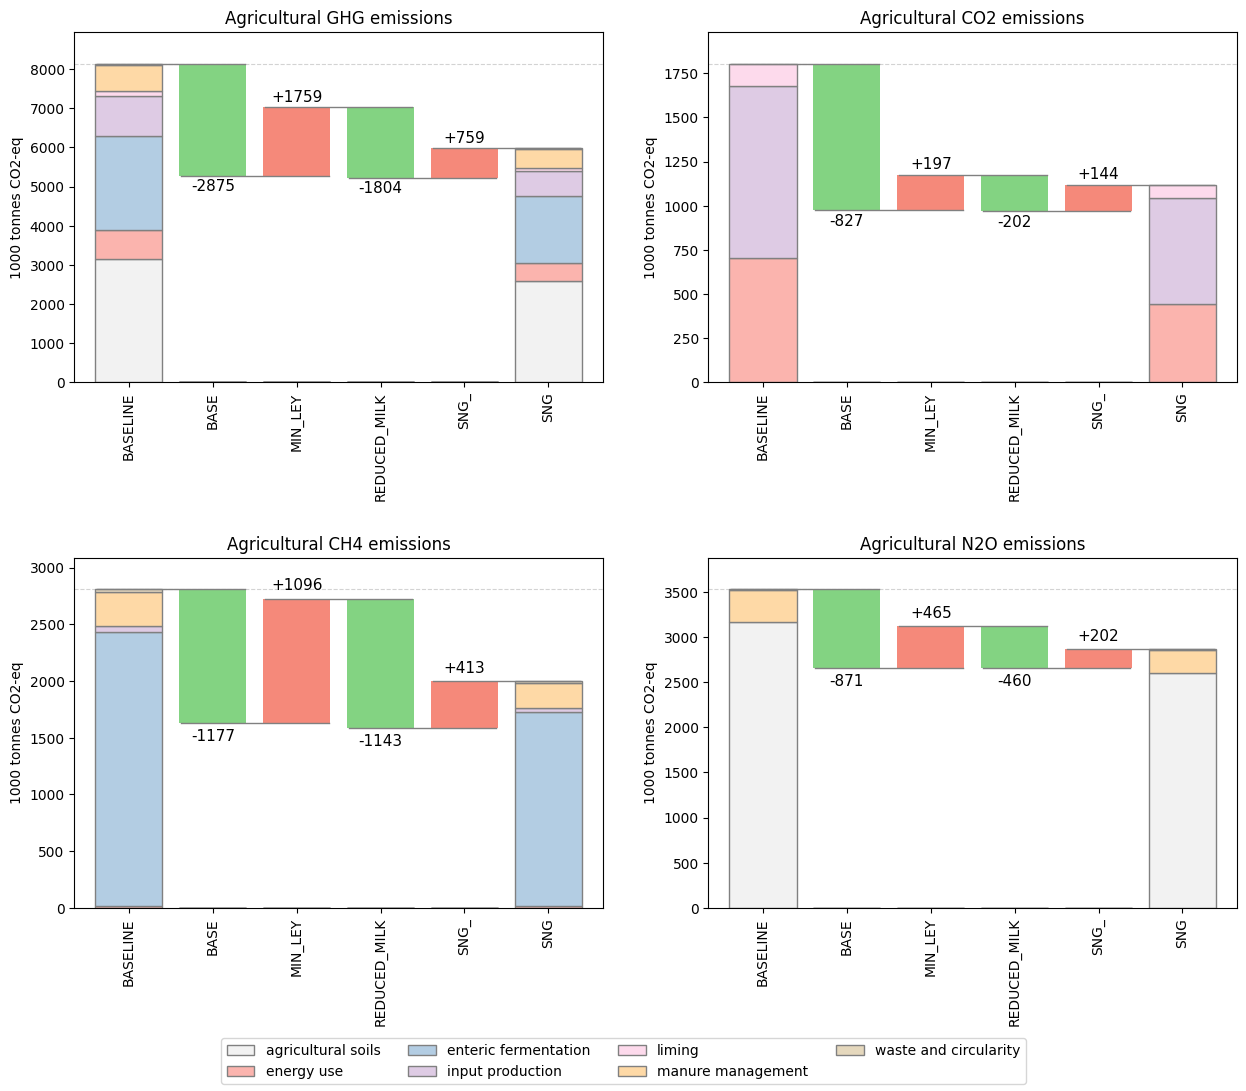

In [84]:
ghg_impacts = (
    cm.impact.get_GHG(session)
    .T.groupby(['compound','process']).sum().T
    .droplevel('year')
)/1e6

def plot_ghg(
    ghgs: list[str] | str | slice,
    title: str,
    ax: plt.Axes | None = None,
    color_map: dict[str, tuple] | None = None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,6))

    if isinstance(ghgs, str):
        ghgs = [ghgs]

    data = ghg_impacts.loc[:,ghgs].T.groupby('process').sum().T

    # Default to cmap, but use explicit color assignment if color_map is passed
    kwargs = { "cmap": cmap }
    if color_map:
        categories = data.columns.unique("process")
        kwargs["color"]=[color_map[cat] for cat in categories]
        del kwargs["cmap"]
        
    plot.waterfall(
        data=data,
        ax=ax,
        edgecolor='grey',
        width=0.8,
        label='absolute',
        **kwargs
    )

    ax.axhline(
        y=data.sum(axis=1).loc["BASELINE"],
        xmin=0, xmax=1, zorder=0, 
        linestyle='--', linewidth=0.8, color='lightgrey'
    )

    ax.set_title(title)
    ax.tick_params(axis='y', which='major')
    ax.set_xlabel('')
    ax.set_ylabel('1000 tonnes CO2-eq')
    ax.set_ylim(top=data.sum(axis=1).max()*1.1)
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

# Create a dict mapping category -> color so that we get consistent color-assignments across
# all subplots (e.g. 'energy use' always has the same color)
categories = ghg_impacts.columns.unique("process").values
cmap = plt.get_cmap('Pastel1', len(categories))
color_map = {category: cmap(i) for i, category in enumerate(categories)}

# Draw plots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
plot_ghg(pd.IndexSlice[:], title="Agricultural GHG emissions", ax=axs[0][0], color_map=color_map)
plot_ghg("CO2", title="Agricultural CO2 emissions", ax=axs[0][1], color_map=color_map)
plot_ghg(["CH4bio", "CH4fos"], title="Agricultural CH4 emissions", ax=axs[1][0], color_map=color_map)
plot_ghg(["N2O", "N2Oind"], title="Agricultural N2O emissions", ax=axs[1][1], color_map=color_map)

# Adjust plots
# ------------

## Remove all the subplot-legends and add a common one for the entire figure
co2e_handles, co2e_labels = axs[0][0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(co2e_handles, co2e_labels, loc="lower center", ncol=4)

## Remove SCN_ as prefix from xtick-labels to get save space
for ax in axs.reshape(-1):
    ax.set_xticklabels([
        item.get_text().removeprefix("SCN_") 
        for item in ax.get_xticklabels()
    ])

## Control the spacing 
fig.subplots_adjust(wspace=0.2, hspace=0.5, bottom=.15)

## Cropland use

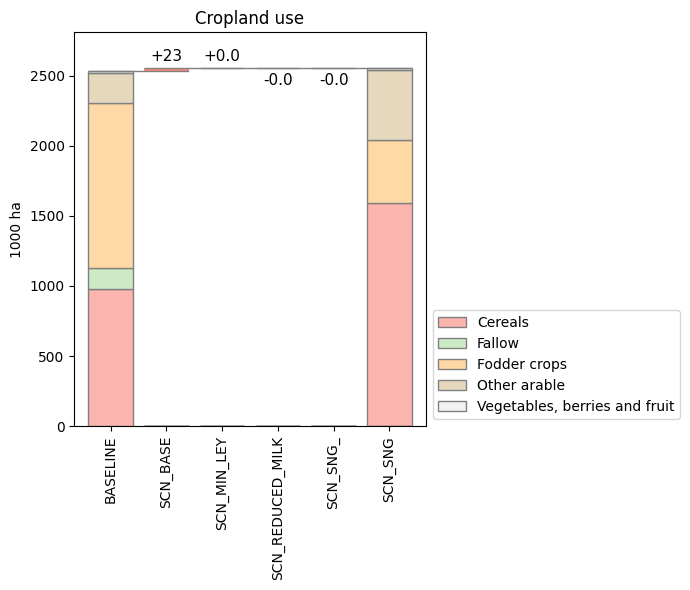

In [86]:
fig, ax = plt.subplots(figsize=(7,6))

plot_data2 = (
    (session.get_attr('C','area',groupby={'crop':'crop_group2'})/1000)
    .drop(['Greenhouse crops','Semi-natural grasslands'], axis=1)
    .droplevel('year')
)

plot.waterfall(
    data=plot_data2,
    ax=ax,
    breaks = ['FAI (demand)'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute'
)

ax.set_title('Cropland use')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 ha')
ax.set_ylim(top=plot_data2.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

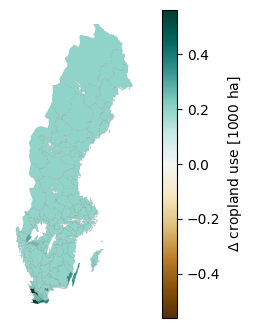

In [89]:
plot_data = (
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    /1000
)
plot_data = (plot_data - plot_data.loc[('BASELINE','2020')])

fig,ax = plt.subplots(figsize=(6,4))

map_data = plot_data.iloc[-1]
lim = abs(map_data).quantile(0.99)
plot.map_from_series(map_data, ax=ax, vmin=-lim, vmax=lim, cmap='BrBG', edgecolor='grey', legend_kwds={'label': r'$\Delta$ cropland use [1000 ha]'})
ax.axis('off')

plt.show()


## Mineral N use

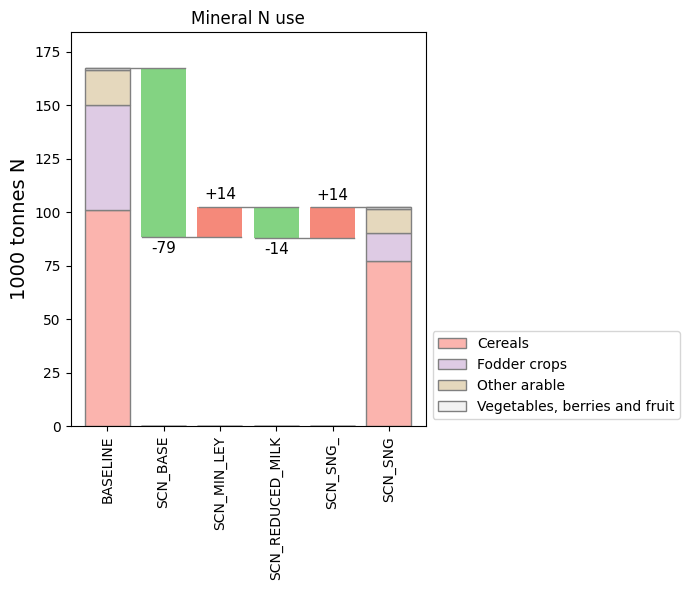

In [87]:
fig, ax = plt.subplots(figsize=(7,6))

plot_data3 = (
    (session.get_attr('C','fertiliser.mineral_N',groupby={'crop':'crop_group2'})/1000000)
    .drop(['Greenhouse crops','Semi-natural grasslands'], axis=1, errors='ignore')
    .droplevel('year')
)

plot.waterfall(
    data=plot_data3,
    ax=ax,
    breaks = ['FAI (demand)'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute'
)

ax.set_title('Mineral N use')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 tonnes N', size=14)
ax.set_ylim(top=plot_data3.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

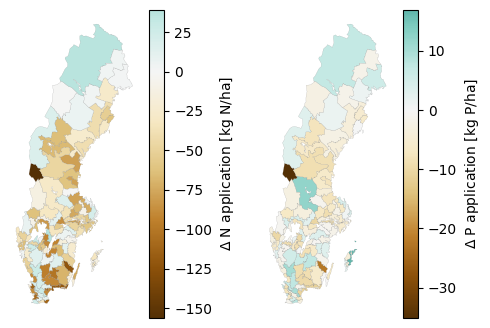

In [92]:
# CHANGES IN N AND P APPLICATION

plot_data_N = (
    (session.get_attr('C','fertiliser.manure_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
)
plot_data_N = (plot_data_N - plot_data_N.loc[('BASELINE','2020')])

plot_data_P = (
    (session.get_attr('C','fertiliser.manure_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
)
plot_data_P = (plot_data_P - plot_data_P.loc[('BASELINE','2020')])

fig,axs = plt.subplots(1,2, figsize=(6,4))

map_data = plot_data_N.iloc[-1]
ax=axs[0]
lim = abs(map_data).quantile(0.99)
plot.map_from_series(map_data, ax=ax, cmap='BrBG', cmap_zero_midpoint='shrink', edgecolor='grey', legend_kwds={'label': r'$\Delta$ N application [kg N/ha]'})
ax.axis('off')

map_data = plot_data_P.iloc[-1]
ax=axs[1]
lim = abs(map_data).quantile(0.99)
plot.map_from_series(map_data, ax=ax, cmap='BrBG', cmap_zero_midpoint='shrink',  edgecolor='grey', legend_kwds={'label': r'$\Delta$ P application [kg P/ha]'})
ax.axis('off')

plt.show()